## Time series analysis & forecasting of Apple Inc. (AAPL) returns & volatility


#### 0. Abstract
Data acquiring and transformation, exploratory analysis and use of forecasting models such as AR, MA, ARMA, GARCH, Stochastic Volatility


In [54]:
#load required libraries, print details of machine and python
import os, sys
import pandas as pd
import numpy as np
import pandas_datareader.data as web
from arch import arch_model
from scipy.stats import norm
from random import gauss
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import statsmodels.stats as sms
import scipy.stats as scs
from scipy import stats, integrate,optimize
import pymc3 as pm
from pymc3.distributions.timeseries import GaussianRandomWalk
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
sns.set_style("dark")
import warnings
warnings.filterwarnings('ignore')
def warn(*args, **kwargs):
    pass
warnings.warn = warn
p = print
p('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
p(sys.version)

Machine: Darwin x86_64

3.6.5 (v3.6.5:f59c0932b4, Mar 28 2018, 03:03:55) 
[GCC 4.2.1 (Apple Inc. build 5666) (dot 3)]


#### 1. Exploratory data analysis (EAD)
Pandas library has built in function to acquire stock prices data from various data providers, in this example IEX exchange is used although daily data is available from many sources. Five years is common minimum optimal period for meaningful analysis.

Classic statistical models for forecasting require data to be stationary which requires data has to have constant mean and standard deviation (stdev). There are several ways to test for stationarity such as intuitive one of calculating mean and stdev at various intervals as well as augmented Dickey-Fuller test(ADF) which tests the null hypothesis that a unit root is present in a time series sample. 

Throughout literature its noted that stock prices do not exhibit stationarity while transformation of it into logarithm changes (returns) is sufficient to ensure stationarity. Results of ADF test on stock prices and return below confirm it.


In [5]:
#download daily stock price of AAPL
start = '2015-11-13'
end = '2018-11-14'
aapl = web.DataReader('AAPL', 'iex', start, end)
aapl.head()

5y


,open,high,low,close,volume
date,,,,,
2015-11-13,109.2685,109.6195,106.4894,106.5558,45812403
2015-11-16,105.6452,108.3579,105.2848,108.2963,38106701
2015-11-17,109.0029,109.1262,107.4853,107.8363,27616939
2015-11-18,109.7997,111.4406,109.5531,111.2509,46674697
2015-11-19,111.5829,113.5842,110.7482,112.6642,43295820


In [7]:
aapl['logarithmicReturns'] = np.log(aapl.close / aapl.close.shift(1))
aapl['HistoricalVolatility'] = aapl.logarithmicReturns.rolling(252).std()*np.sqrt(252)
aapl['tim'] = pd.to_datetime(aapl.index, format='%Y-%m-%d')
aapl = aapl.set_index('tim')
aapl = aapl.fillna(method='bfill')
result = adfuller(aapl.close)

print('ADF Statistic of AAPL prices: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))
    
result = adfuller(aapl.logarithmicReturns)
print('ADF Statistic of AAPL returns: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic of AAPL prices: -0.614025
p-value: 0.867781
	1%: -3.439
	5%: -2.865
	10%: -2.569
ADF Statistic of AAPL returns: -25.912336
p-value: 0.000000
	1%: -3.439
	5%: -2.865
	10%: -2.569


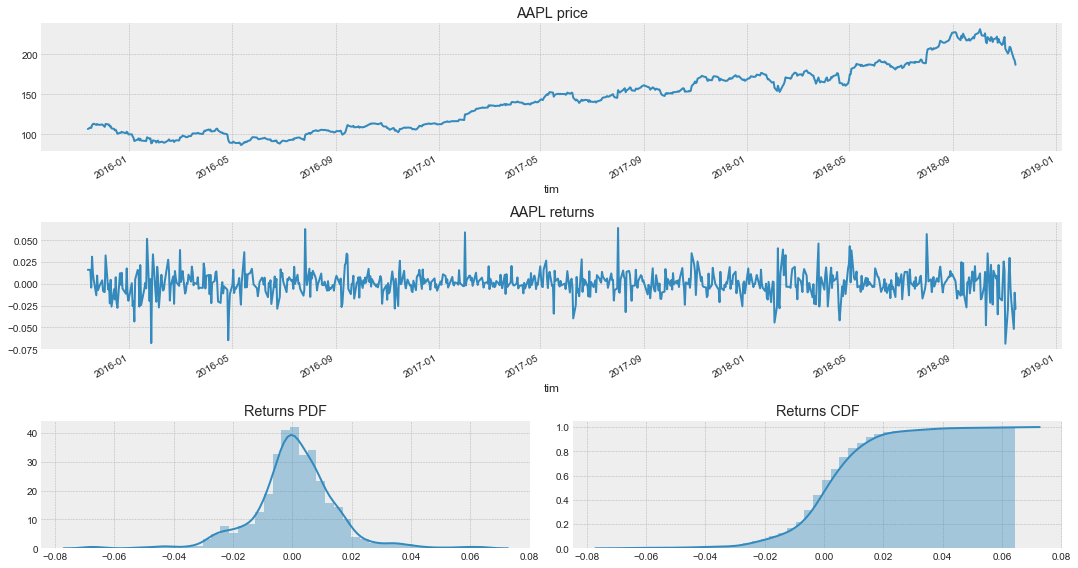

In [8]:
def tsplot(y,tit, lags=None, figsize=(15, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0),colspan=2)
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        aapl['close'].plot(ax=ts_ax,title='AAPL price')
        aapl['logarithmicReturns'].plot(ax=acf_ax,title='AAPL returns')
        sns.distplot(aapl['logarithmicReturns'].values,ax=qq_ax, hist=True).set_title('Returns PDF')
        sns.distplot(aapl['logarithmicReturns'].values,hist_kws=dict(cumulative=True),kde_kws=dict(cumulative=True),ax=pp_ax).set_title('Returns CDF')
        plt.tight_layout()
    return 
tsplot(aapl.close,"AAPL price")

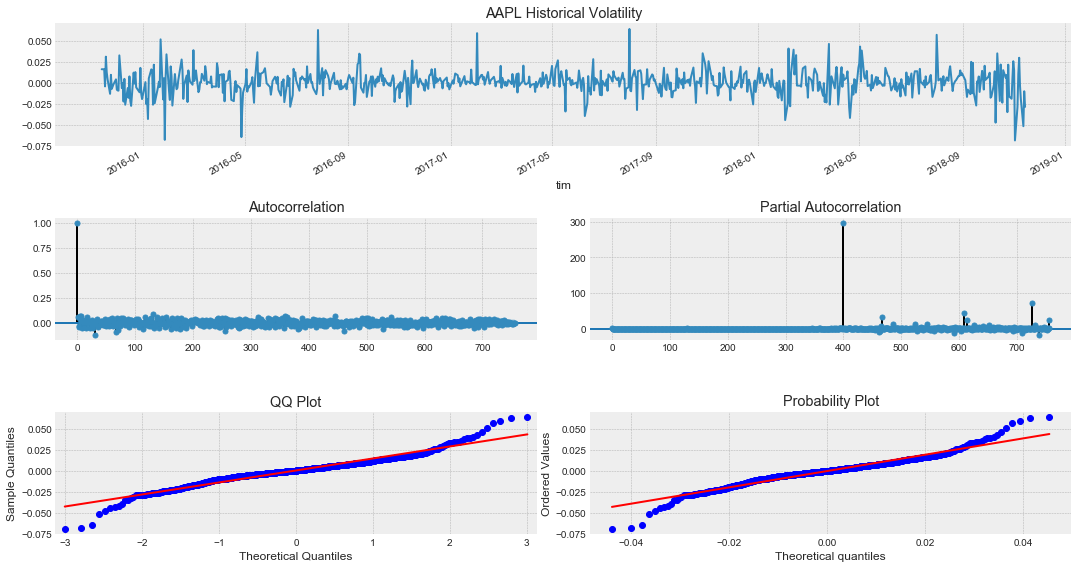

In [10]:
def tsplot(y, lags=None, figsize=(15, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        y.plot(ax=ts_ax)
        ts_ax.set_title('AAPL Historical Volatility')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        plt.tight_layout()
    return 
tsplot(aapl['logarithmicReturns'])

In [ ]:
#https://medium.com/datadriveninvestor/how-to-build-exponential-smoothing-models-using-python-simple-exponential-smoothing-holt-and-da371189e1a1

#### 2. Methods
2.1 AR

In [36]:
arMod = ARIMA(aapl.logarithmicReturns, order=(1,0,0)).fit(method='mle', trend='nc', disp=0)
arModLjungBox = sms.diagnostic.acorr_ljungbox(arMod.resid, lags=[20], boxpierce=True)
print(arMod.summary())

                              ARMA Model Results                              
Dep. Variable:     logarithmicReturns   No. Observations:                  757
Model:                     ARMA(1, 0)   Log Likelihood                2141.298
Method:                           mle   S.D. of innovations              0.014
Date:                Tue, 18 Dec 2018   AIC                          -4278.595
Time:                        18:22:49   BIC                          -4269.337
Sample:                             0   HQIC                         -4275.029
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ar.L1.logarithmicReturns     0.0586      0.036      1.612      0.107      -0.013       0.130
                                    Roots                                    
           

2.2 MA

In [37]:
maMod = ARIMA(aapl.logarithmicReturns, order=(0,0,1)).fit(method='mle', trend='nc', disp=0)
maModLjungBox = sms.diagnostic.acorr_ljungbox(arMod.resid, lags=[20], boxpierce=True)
print(maMod.summary())

                              ARMA Model Results                              
Dep. Variable:     logarithmicReturns   No. Observations:                  757
Model:                     ARMA(0, 1)   Log Likelihood                2141.374
Method:                           mle   S.D. of innovations              0.014
Date:                Tue, 18 Dec 2018   AIC                          -4278.749
Time:                        18:23:02   BIC                          -4269.490
Sample:                             0   HQIC                         -4275.183
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ma.L1.logarithmicReturns     0.0619      0.037      1.667      0.096      -0.011       0.135
                                    Roots                                    
           

2.3 ARMA(1,1)

In [38]:
arimaMod = ARIMA(aapl.logarithmicReturns, order=(1,0,1)).fit(method='mle', trend='nc', disp=0)
arimaModLjungBox = sms.diagnostic.acorr_ljungbox(arMod.resid, lags=[20], boxpierce=True)
print(arimaMod.summary())

                              ARMA Model Results                              
Dep. Variable:     logarithmicReturns   No. Observations:                  757
Model:                     ARMA(1, 1)   Log Likelihood                2141.449
Method:                           mle   S.D. of innovations              0.014
Date:                Tue, 18 Dec 2018   AIC                          -4276.898
Time:                        18:23:21   BIC                          -4263.009
Sample:                             0   HQIC                         -4271.548
                                                                              
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
ar.L1.logarithmicReturns    -0.1311      0.333     -0.394      0.693      -0.783       0.521
ma.L1.logarithmicReturns     0.1926      0.328      0.588      0.557      -0.450       0.

2.4 Dynamic ARMA(p,q)

In [39]:
def bestArMod(TS):
    aic = np.inf 
    order = None
    mdl = None
    pq = range(3)
    for i in pq:
        for j in pq:
            try:
                tmpMdl = ARIMA(TS, order=(i,0,j)).fit(method='mle', trend='nc', disp=0)
                tmpAic = tmpMdl.aic
                if tmpAic < aic:
                    aic = tmpAic
                    order = (i, 0, j)
                    mdl = tmpMdl
            except: continue
    return mdl
DynArimaMod = bestArMod(np.asarray(aapl['logarithmicReturns']))
DynArimaModLjungBox = sms.diagnostic.acorr_ljungbox(DynArimaMod.resid, lags=[20], boxpierce=True)
print(DynArimaMod.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                  757
Model:                     ARMA(2, 2)   Log Likelihood                2144.615
Method:                           mle   S.D. of innovations              0.014
Date:                Tue, 18 Dec 2018   AIC                          -4279.231
Time:                        18:23:37   BIC                          -4256.084
Sample:                             0   HQIC                         -4270.315
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y       -0.7376      0.102     -7.227      0.000      -0.938      -0.538
ar.L2.y       -0.8218      0.126     -6.508      0.000      -1.069      -0.574
ma.L1.y        0.8006      0.097      8.213      0.0

2.5 Garch(1,1)

In [34]:
garch11Mod = arch_model(aapl['logarithmicReturns'], p=1, q=1).fit(update_freq=5, disp='off')
print(garch11Mod.summary())

                     Constant Mean - GARCH Model Results                      
Dep. Variable:     logarithmicReturns   R-squared:                      -0.003
Mean Model:             Constant Mean   Adj. R-squared:                 -0.003
Vol Model:                      GARCH   Log-Likelihood:                2166.16
Distribution:                  Normal   AIC:                          -4324.31
Method:            Maximum Likelihood   BIC:                          -4305.79
                                        No. Observations:                  757
Date:                Tue, Dec 18 2018   Df Residuals:                      753
Time:                        18:22:14   Df Model:                            4
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.4976e-03  5.543e-04      2.702  6.892e-03 [4.

2.6 Simple exponential smoothing

In [41]:
sesMod = SimpleExpSmoothing(aapl['logarithmicReturns']).fit(smoothing_level=0.2,optimized=False)


2.7 Holts 

In [48]:
holtMod = Holt(aapl['logarithmicReturns']).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)

2.8 Holt-Winters 

In [52]:
esMod = ExponentialSmoothing(aapl['logarithmicReturns'], seasonal_periods=4, trend='add', seasonal='add').fit(use_boxcox=False)

2.9 Stochastic Volatility

In [55]:
with pm.Model() as model:
    step_size = pm.Exponential('sigma', 50.)
    s = GaussianRandomWalk('s', sd=step_size,shape=len(aapl['logarithmicReturns']))
    nu = pm.Exponential('nu', .1)
    r = pm.StudentT('r', nu=nu,lam=pm.math.exp(-2*s),observed=aapl['logarithmicReturns'])

In [ ]:
with model:
    trace = pm.sample(10000, tune=1000, nuts_kwargs=dict(target_accept=.9))

pm.traceplot(trace, varnames=['sigma', 'nu']);
sns.set()
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(abs(settle_price2.settle_priceRet))
ax.plot(np.exp(trace[s].T-1), 'r', alpha=.002);
ax.set(xlabel='time', ylabel='returns',ylim=[0,0.25],title='Stochastic Volatility predictions')
ax.legend(['SPX', 'stoch vol']);

